# VR CO2 Study - Data processing

This notebook does the following:

1. x
2. y
3. z

Input: input
Output: output

In [2]:
import pandas as pd
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils.plots import plot_features_time_series, contact_gsr_line_plot, plot_segment_violin
from utils.Tests import Tests
import statsmodels.formula.api as smf

In [3]:
# Create new directory for notebook output
notebook_temp_dir = os.path.join(os.getcwd(), "temp", "3_statistics")

if not os.path.exists(notebook_temp_dir):
    os.makedirs(notebook_temp_dir)

In [4]:
# File containing features for entire segments
segment_features_file = 'D:\\co2-study\\temp\\segment_features.csv'
segment_features = pd.read_csv(segment_features_file, index_col=0)

# File containing features for windows of data
windowed_features_file = 'D:\\co2-study\\temp\\windowed_features.csv'
windowed_features = pd.read_csv(windowed_features_file, index_col=0)

In [5]:
# Filter the data for 'air' and 'co2' conditions with 'gas_inhalation' segment
gas_inhalation_segments = segment_features[(segment_features['Condition'].isin(['AIR', 'CO2'])) & (segment_features['Segment'] == 'gas_inhalation')]
gas_inhalation_windows = windowed_features[(windowed_features['Condition'].isin(['AIR', 'CO2'])) & (windowed_features['Segment'] == 'gas_inhalation')]
gas_inhalation_segments = gas_inhalation_segments.dropna()
gas_inhalation_windows = gas_inhalation_windows.dropna()


# Calculate mean combined pupil size using left and right pupils
gas_inhalation_segments['pupil_size_combined'] = (gas_inhalation_segments['VerboseData.Left.PupilDiameterMm_mean'] + gas_inhalation_segments['VerboseData.Right.PupilDiameterMm_mean']) / 2
gas_inhalation_windows['pupil_size_combined'] = (gas_inhalation_windows['VerboseData.Left.PupilDiameterMm_mean'] + gas_inhalation_windows['VerboseData.Right.PupilDiameterMm_mean']) / 2

# add window index for each participant/condition
window_index = pd.DataFrame({'window_index': gas_inhalation_windows.groupby(['participant_number', 'Condition']).cumcount()})
gas_inhalation_windows.insert(3, 'window_index', window_index['window_index'])

# GSR


In [6]:
# Filter GSR data for segmented and windowed data
gsr_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Biopac_GSR_)').reset_index(drop=True)
gsr_air_segments = gsr_data_segments[gsr_data_segments['Condition']=='AIR']
gsr_co2_segments = gsr_data_segments[gsr_data_segments['Condition']=='CO2']

gsr_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Biopac_GSR_)').reset_index(drop=True)
gsr_air_windows = gsr_data_windows[gsr_data_windows['Condition']=='AIR']
gsr_co2_windows = gsr_data_windows[gsr_data_windows['Condition']=='CO2']

In [7]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(gsr_air_segments['Biopac_GSR_mean'], 'AIR')
Tests.normality_test_sw(gsr_co2_segments['Biopac_GSR_mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9097617268562317
Shapiro-Wilk Test - p-value: 0.0017018801299855113
Data for AIR condition is NOT normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.9044846892356873
Shapiro-Wilk Test - p-value: 0.0011468266602605581
Data for CO2 condition is NOT normally distributed.


ShapiroResult(statistic=0.9044846892356873, pvalue=0.0011468266602605581)

In [8]:
# 
Tests.paired_t_test(gsr_air_segments['Biopac_GSR_mean'],gsr_co2_segments['Biopac_GSR_mean'])

T-statistic: -8.538
P-value: 0.000
SIGNIFICANT difference found.


(-8.538469607064895, 5.748323645578251e-11)

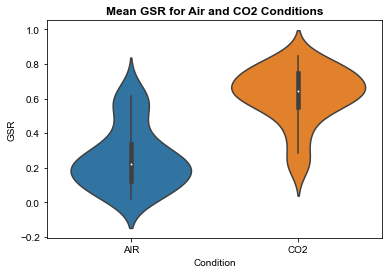

In [9]:
plot_segment_violin(gsr_data_segments, 'Biopac_GSR_mean', 'Mean GSR for Air and CO2 Conditions', 'Condition', 'GSR', 
                    notebook_temp_dir)

In [30]:
air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(gsr_air_windows, gsr_co2_windows, gsr_data_windows, 'Biopac_GSR_mean', 2)

Running mixed polynomial regression model independently for air and co2 conditions for: Biopac_GSR_mean
Air condition: Biopac_GSR_mean increases by -0.003 units per window
CO2 condition: Biopac_GSR_mean increases by 0.008 units per window
Running one mixed polynomial regression model with condition as an independent variable: Biopac_GSR_mean
Biopac_GSR_mean in CO2 condition is on average higher by 0.280
                 Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    Biopac_GSR_mean
No. Observations:     10438      Method:                REML           
No. Groups:           46         Scale:                 0.0343         
Min. group size:      164        Log-Likelihood:        2671.8496      
Max. group size:      230        Converged:             Yes            
Mean group size:      226.9                                            
-----------------------------------------------------------------------
                              Coef

C:\Users\m\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


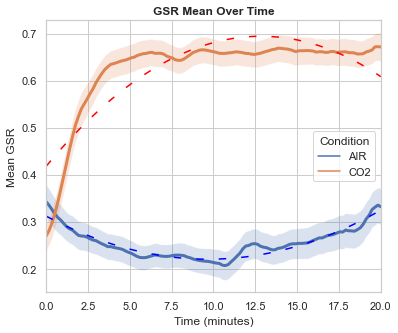

In [11]:
plot_features_time_series(gas_inhalation_windows, 'Biopac_GSR_mean', 'GSR Mean Over Time', 'Time (minutes)', 'Mean GSR', 
                          os.path.join(notebook_temp_dir, "GSR_mean_over_time"), air_prediction_line, co2_prediction_line)

# RSP


In [12]:
# RSP
rsp_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|window_index|Biopac_RSP_|RSP_)').reset_index(drop=True)
rsp_air_segments = rsp_data_segments[rsp_data_segments['Condition']=='AIR']
rsp_co2_segments = rsp_data_segments[rsp_data_segments['Condition']=='CO2']

rsp_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Biopac_RSP_|RSP_)').reset_index(drop=True)
rsp_air_windows = rsp_data_windows[rsp_data_windows['Condition']=='AIR']
rsp_co2_windows = rsp_data_windows[rsp_data_windows['Condition']=='CO2']

In [13]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(rsp_air_segments['RSP_Rate_Mean'], 'AIR')
Tests.normality_test_sw(rsp_co2_segments['RSP_Rate_Mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9675655364990234
Shapiro-Wilk Test - p-value: 0.22444088757038116
Data for AIR condition is  normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.9650021195411682
Shapiro-Wilk Test - p-value: 0.1791263073682785
Data for CO2 condition is  normally distributed.


ShapiroResult(statistic=0.9650021195411682, pvalue=0.1791263073682785)

In [14]:
Tests.paired_t_test(rsp_air_segments['RSP_Rate_Mean'],rsp_co2_segments['RSP_Rate_Mean'])

T-statistic: -14.216
P-value: 0.000
SIGNIFICANT difference found.


(-14.21639544143445, 2.9644907837639765e-18)

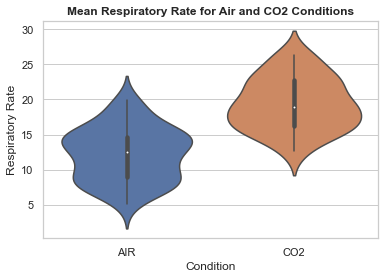

In [15]:
plot_segment_violin(rsp_data_segments, 'RSP_Rate_Mean', 'Mean Respiratory Rate for Air and CO2 Conditions', 'Condition', 'Respiratory Rate', 
                    notebook_temp_dir)

In [31]:
air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(rsp_air_windows, rsp_co2_windows, rsp_data_windows, 'RSP_Rate_Mean', 2)

Running mixed polynomial regression model independently for air and co2 conditions for: RSP_Rate_Mean
Air condition: RSP_Rate_Mean increases by 0.008 units per window
CO2 condition: RSP_Rate_Mean increases by 0.190 units per window
Running one mixed polynomial regression model with condition as an independent variable: RSP_Rate_Mean
RSP_Rate_Mean in CO2 condition is on average higher by 3.989
                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     RSP_Rate_Mean
No. Observations:      10438       Method:                 REML         
No. Groups:            46          Scale:                  7.8005       
Min. group size:       164         Log-Likelihood:         -25676.3408  
Max. group size:       230         Converged:              Yes          
Mean group size:       226.9                                            
------------------------------------------------------------------------
                              Coef.  S

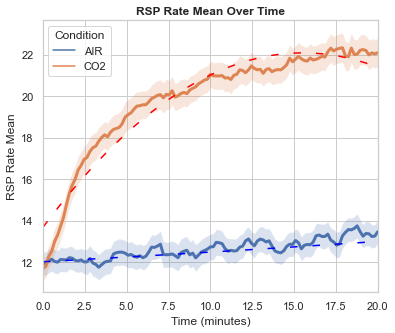

In [32]:
plot_features_time_series(gas_inhalation_windows, 'RSP_Rate_Mean', 'RSP Rate Mean Over Time', 'Time (minutes)', 'RSP Rate Mean', os.path.join(notebook_temp_dir, "RSP_mean_over_time"), air_prediction_line, co2_prediction_line)

# HR


In [18]:
# HR
#TODO: Using emteqPRO's HR because feature extraction when using entire segments sets HR features to nan per outlier rejection
hr_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|PPG_|HRV_|HeartRate/Average_mean)').reset_index(drop=True)
hr_data_segments.rename(columns = {'HeartRate/Average_mean':'HeartRate_Average_mean'}, inplace = True)
hr_air_segments = hr_data_segments[hr_data_segments['Condition']=='AIR']
hr_co2_segments = hr_data_segments[hr_data_segments['Condition']=='CO2']

hr_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|PPG_|HRV_|HeartRate/Average_mean)').reset_index(drop=True)
hr_data_windows.rename(columns = {'HeartRate/Average_mean':'HeartRate_Average_mean'}, inplace = True)
hr_air_windows = hr_data_windows[hr_data_windows['Condition']=='AIR']
hr_co2_windows = hr_data_windows[hr_data_windows['Condition']=='CO2']

In [19]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(hr_air_segments['PPG_Rate_Mean'], 'AIR')
Tests.normality_test_sw(hr_co2_segments['PPG_Rate_Mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9768682718276978
Shapiro-Wilk Test - p-value: 0.48405978083610535
Data for AIR condition is  normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.9863318800926208
Shapiro-Wilk Test - p-value: 0.8591641783714294
Data for CO2 condition is  normally distributed.


ShapiroResult(statistic=0.9863318800926208, pvalue=0.8591641783714294)

In [20]:
Tests.paired_t_test(hr_air_segments['HeartRate_Average_mean'],hr_co2_segments['PPG_Rate_Mean'])

T-statistic: -45.533
P-value: 0.000
SIGNIFICANT difference found.


(-45.532907553866664, 2.755483963788822e-39)

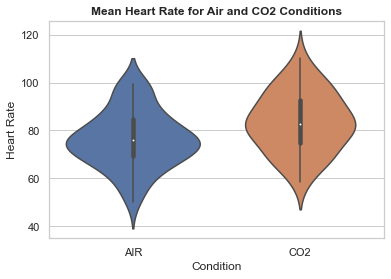

In [21]:
plot_segment_violin(hr_data_segments, 'PPG_Rate_Mean', 'Mean Heart Rate for Air and CO2 Conditions', 'Condition', 'Heart Rate', 
                    notebook_temp_dir)

In [33]:
air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(hr_air_windows, hr_co2_windows, hr_data_windows, 'PPG_Rate_Mean', 2)

Running mixed polynomial regression model independently for air and co2 conditions for: PPG_Rate_Mean
Air condition: PPG_Rate_Mean increases by -0.020 units per window
CO2 condition: PPG_Rate_Mean increases by 0.173 units per window
Running one mixed polynomial regression model with condition as an independent variable: PPG_Rate_Mean
PPG_Rate_Mean in CO2 condition is on average higher by -0.665
                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     PPG_Rate_Mean
No. Observations:       10438       Method:                 REML         
No. Groups:             46          Scale:                  25.0125      
Min. group size:        164         Log-Likelihood:         -31784.5471  
Max. group size:        230         Converged:              Yes          
Mean group size:        226.9                                            
-------------------------------------------------------------------------
                            

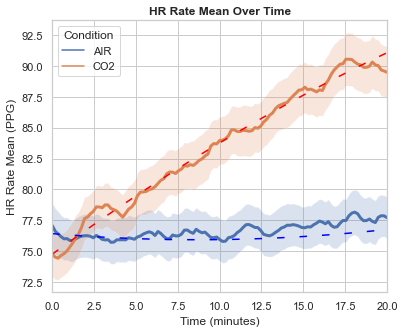

In [34]:
plot_features_time_series(gas_inhalation_windows, 'PPG_Rate_Mean', 'HR Rate Mean Over Time', 'Time (minutes)', 'HR Rate Mean (PPG)', os.path.join(notebook_temp_dir, "HR_mean_over_time_PPG"), air_prediction_line, co2_prediction_line)

# Pupil Size

In [35]:
# Pupil size
pupil_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|VerboseData.|pupil_)').reset_index(drop=True)
#pupil_data_segments['pupil_size_combined'] = (pupil_data_segments['VerboseData.Left.PupilDiameterMm_mean'] + pupil_data_segments['VerboseData.Right.PupilDiameterMm_mean']) / 2

pupil_air_segments = pupil_data_segments[pupil_data_segments['Condition']=='AIR']
pupil_co2_segments = pupil_data_segments[pupil_data_segments['Condition']=='CO2']

pupil_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|VerboseData.|pupil_)').reset_index(drop=True)
pupil_air_windows = pupil_data_windows[pupil_data_windows['Condition']=='AIR']
pupil_co2_windows = pupil_data_windows[pupil_data_windows['Condition']=='CO2']

In [36]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(pupil_air_segments['pupil_size_combined'], 'AIR')
Tests.normality_test_sw(pupil_co2_segments['pupil_size_combined'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9481764435768127
Shapiro-Wilk Test - p-value: 0.03990786895155907
Data for AIR condition is NOT normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.977023184299469
Shapiro-Wilk Test - p-value: 0.48974671959877014
Data for CO2 condition is  normally distributed.


ShapiroResult(statistic=0.977023184299469, pvalue=0.48974671959877014)

In [37]:
Tests.paired_t_test(pupil_air_segments['pupil_size_combined'],pupil_co2_segments['pupil_size_combined'])

T-statistic: -1.527
P-value: 0.134
No singificant results found.


(-1.5266319540258766, 0.13385126981008785)

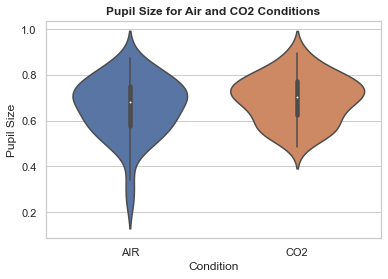

In [38]:
plot_segment_violin(pupil_data_segments, 'pupil_size_combined', 'Pupil Size for Air and CO2 Conditions', 'Condition', 'Pupil Size', 
                    notebook_temp_dir)

In [39]:
air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(pupil_air_windows, pupil_co2_windows, pupil_data_windows, 'pupil_size_combined', 2)

Running mixed polynomial regression model independently for air and co2 conditions for: pupil_size_combined
Air condition: pupil_size_combined increases by -0.002 units per window
CO2 condition: pupil_size_combined increases by -0.006 units per window
Running one mixed polynomial regression model with condition as an independent variable: pupil_size_combined
pupil_size_combined in CO2 condition is on average higher by 0.011
                 Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   pupil_size_combined
No. Observations:    10438     Method:               REML               
No. Groups:          46        Scale:                0.0167             
Min. group size:     164       Log-Likelihood:       6413.1742          
Max. group size:     230       Converged:            Yes                
Mean group size:     226.9                                              
------------------------------------------------------------------------
      

C:\Users\m\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


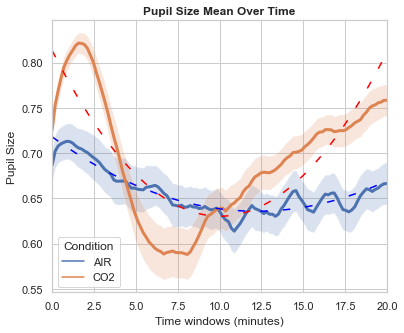

In [40]:
plot_features_time_series(gas_inhalation_windows, 'pupil_size_combined', 'Pupil Size Mean Over Time', 'Time windows (minutes)', 'Pupil Size', os.path.join(notebook_temp_dir, "Pupil_size"), air_prediction_line, co2_prediction_line)

# EMG Contact

In [ ]:
# Pupil size
contact_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Emg/Contact)').reset_index(drop=True)

contact_air_segments = contact_data_segments[contact_data_segments['Condition']=='AIR']
contact_co2_segments = contact_data_segments[contact_data_segments['Condition']=='CO2']

contact_data_windows = windowed_features.filter(regex=r'^(participant_number|Condition|Segment|Emg/Contact)').reset_index(drop=True)
contact_air_windows = contact_data_windows[contact_data_windows['Condition']=='AIR']
contact_co2_windows = contact_data_windows[contact_data_windows['Condition']=='CO2']

In [ ]:
# Shapiro-Wilk test for normality


In [ ]:
# Create the violin plot
sns.violinplot(x='Condition', y='Emg/Contact[RightOrbicularis]_mean', data=contact_data_segments)

# Customize plot titles and labels
sns.set(style='whitegrid')
plt.title('Mean Pupil Size for Air and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('Pupil Size Mean')

# Display the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = contact_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=['Emg/Contact[RightOrbicularis]_mean', 'Emg/Contact[RightZygomaticus]_mean', 'Emg/Contact[RightFrontalis]_mean', 'Emg/Contact[CenterCorrugator]_mean', 'Emg/Contact[LeftFrontalis]_mean', 'Emg/Contact[LeftZygomaticus]_mean', 'Emg/Contact[LeftOrbicularis]_mean'], var_name='Muscle', value_name='Emg_Contact')

# Define the order of the muscles for plotting
muscle_order = ['RightOrbicularis', 'RightZygomaticus', 'RightFrontalis', 'CenterCorrugator', 'LeftFrontalis', 'LeftZygomaticus', 'LeftOrbicularis']

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='Emg_Contact', hue='Muscle', data=melted_data, scale='width', linewidth=0.5)


# Customize the plot
plt.title('EMG/Contact for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('EMG/Contact')
plt.legend(title='Muscle')

# Show the plot
plt.show()


In [ ]:
muscles = ['LeftOrbicularis','RightOrbicularis', 'LeftFrontalis', 'RightFrontalis', 'LeftZygomaticus', 'RightZygomaticus', 'CenterCorrugator']

for muscle in muscles:
    muscle_name = f'Emg/Contact[{muscle}]_mean'
    plot_title = f'{muscle} Mean Over Time'
    contact_gsr_line_plot(gas_inhalation_windows, muscle_name, plot_title, notebook_temp_dir)


# Correlation Matrix

In [ ]:
# Generate correlation matrix
# create a list of column names that contain "mean" or "Mean"
mean_columns = gas_inhalation_windows.columns[gas_inhalation_windows.columns.str.contains('_mean|_Mean|HRV|SCR_Peaks_N|RSP_Phase_Duration_Ratio|EDA_Tonic_SD|pupil_size_combined')].tolist()
mean_columns = list(filter(lambda item: 'derivative' not in item, mean_columns))
mean_columns = list(filter(lambda item: 'Filtered' not in item, mean_columns))
mean_columns.remove('Ppg/Raw.ppg_mean')

# select only the columns that contain "mean" or "Mean"
df = gas_inhalation_windows[mean_columns]
#df_mean = df_mean.dropna()

# Shorten column names
df.rename(columns={
    'Emg/Contact[RightOrbicularis]_mean': 'Emg/C(RO)',
    'Emg/Amplitude[RightOrbicularis]_mean': 'Emg/A(RO)',
    'Emg/Contact[RightZygomaticus]_mean': 'Emg/C(RZ)',
    'Emg/Amplitude[RightZygomaticus]_mean': 'Emg/A(RZ)',
    'Emg/Contact[CenterCorrugator]_mean': 'Emg/C(CC)',
    'Emg/Amplitude[CenterCorrugator]_mean': 'Emg/A(CC)',
    'Emg/Contact[RightFrontalis]_mean': 'Emg/C(RF)',
    'Emg/Amplitude[RightFrontalis]_mean': 'Emg/A(RF)',
    'Emg/Contact[LeftOrbicularis]_mean': 'Emg/C(LO)',
    'Emg/Amplitude[LeftOrbicularis]_mean': 'Emg/A(LO)',
    'Emg/Contact[LeftZygomaticus]_mean': 'Emg/C(LZ)',
    'Emg/Amplitude[LeftZygomaticus]_mean': 'Emg/A(LZ)',
    'Emg/Contact[LeftFrontalis]_mean': 'Emg/C(LF)',
    'Emg/Amplitude[LeftFrontalis]_mean': 'Emg/A(LF)',
    'Emg/Amplitude[LeftFrontalis]_mean': 'Emg/A(LF)',
    
    'HeartRate/Average_mean': 'HeartRate(EmteqPro)',
    'PPG_Rate_Mean': 'HeartRate(feature)',
    'Accelerometer/Raw.x_mean': 'Acc(X)',
    'Accelerometer/Raw.y_mean': 'Acc(Y)',
    'Accelerometer/Raw.z_mean': 'Acc(Z)',
    'Gyroscope/Raw.x_mean': 'Gyr(X)',
    'Gyroscope/Raw.y_mean': 'Gyr(Y)',
    'Gyroscope/Raw.z_mean': 'Gyr(Z)',
    'pupil_size_combined': 'PupilSize(Combined)',
    'VerboseData.Right.PupilDiameterMm_mean': 'PupilSize(Right)',
    'VerboseData.Left.PupilDiameterMm_mean': 'PupilSize(Left)',
    'Biopac_GSR_mean': 'GSR',
    'SCR_Peaks_Amplitude_Mean': 'SCR_Peaks_Amp',
    'Biopac_RSP_mean': 'RSP',
    'RSP_Rate_Mean': 'RSP_Rate',
    'RSP_Amplitude_Mean': 'RSP_Amp',
    'RSP_Phase_Duration_Ratio': 'RSP_Phase_Dur_Ratio',
    
    # Add the remaining column name mappings here
}, inplace=True)



In [ ]:
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# compute the correlation matrix
corr_matrix = df.corr(method=lambda x, y: pearsonr(x, y)[0])

# compute the p-values for each correlation coefficient
p_values = df.corr(method=lambda x, y: pearsonr(x, y)[1])

# adjust the p-values using FDR control
reject, p_values_fdr = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_by')[:2]
p_values_fdr = pd.DataFrame(p_values_fdr.reshape(p_values.shape), index=p_values.index, columns=p_values.columns)

# use the adjusted p-values to filter the correlation matrix
#corr_matrix_fdr = corr_matrix.where(p_values_fdr < 0.05)
#p_values_fdr = p_values_fdr.where(p_values_fdr < 0.05)


# dont filter based on fdr
corr_matrix_fdr = corr_matrix

# Save CSV
#corr_matrix_fdr.to_csv(os.path.join(notebook_temp_dir, "correlation_matrix_test_statistic.csv"))
#p_values_fdr.to_csv(os.path.join(notebook_temp_dir, "correlation_matrix_p_values.csv"))


In [ ]:
import seaborn as sns
# select the subset of columns you want to plot
subset_cols = ['GSR', 'RSP_Rate']

# select the subset of the correlation matrix you want to plot
corr_matrix_fdr_subset = corr_matrix_fdr[subset_cols][subset_cols]

# create a boolean mask for rows where the index contains "Contact" or "Pupil"
#mask = corr_matrix_fdr_subset.index.str.contains("Contact|Pupil")
mask = corr_matrix_fdr_subset.index.str.contains("Contact|Amplitude|PPG|Accelerometer|HeartRate|PupilDiameterMm_mean|RSP_")

# use boolean indexing to select the rows that meet the condition
corr_matrix_fdr_subset = corr_matrix_fdr_subset.loc[mask]

#corr_matrix_fdr_subset = corr_matrix_fdr_subset.fillna('')
# Create heatmap using seaborn
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix_fdr, annot=False, cmap='coolwarm', square=False)
